In [31]:
import torch
import torch.nn as nn
from torch.cuda.amp import autocast
from fph import FPH
from swins import SwinTransformerV2
import torch.nn.functional as F
from functools import partial
import math
import warnings
from tqdm.notebook import tqdm

In [2]:
def drop_path(x, drop_prob: float = 0., training: bool = False):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).

    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.

    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

In [3]:
def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    # Cut & paste from PyTorch official master until it's in a few official releases - RW
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor


def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # type: (Tensor, float, float, float, float) -> Tensor
    r"""Fills the input Tensor with values drawn from a truncated
    normal distribution. The values are effectively drawn from the
    normal distribution :math:`\mathcal{N}(\text{mean}, \text{std}^2)`
    with values outside :math:`[a, b]` redrawn until they are within
    the bounds. The method used for generating the random values works
    best when :math:`a \leq \text{mean} \leq b`.
    Args:
        tensor: an n-dimensional `torch.Tensor`
        mean: the mean of the normal distribution
        std: the standard deviation of the normal distribution
        a: the minimum cutoff value
        b: the maximum cutoff value
    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.trunc_normal_(w)
    """
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)

In [4]:
def initialize_decoder(module):
    for m in module.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_uniform_(m.weight, mode="fan_in", nonlinearity="relu")
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
def initialize_head(module):
    for m in module.modules():
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

class SegmentationModel(nn.Module):
    """Base class for all segmentation models."""

    # if model supports shape not divisible by 2 ^ n
    # set to False
    requires_divisible_input_shape = True

    def initialize(self):
        initialize_decoder(self.decoder)
        initialize_head(self.segmentation_head)
        if self.classification_head is not None:
            initialize_head(self.classification_head)

    def check_input_shape(self, x):
        """Check if the input shape is divisible by the output stride.
        If not, raise a RuntimeError.
        """
        h, w = x.shape[-2:]
        output_stride = self.encoder.output_stride
        if h % output_stride != 0 or w % output_stride != 0:
            new_h = (
                (h // output_stride + 1) * output_stride
                if h % output_stride != 0
                else h
            )
            new_w = (
                (w // output_stride + 1) * output_stride
                if w % output_stride != 0
                else w
            )
            raise RuntimeError(
                f"Wrong input shape height={h}, width={w}. Expected image height and width "
                f"divisible by {output_stride}. Consider pad your images to shape ({new_h}, {new_w})."
            )

    def forward(self, x):
        """Sequentially pass `x` trough model`s encoder, decoder and heads"""

        if not torch.jit.is_tracing() or self.requires_divisible_input_shape:
            self.check_input_shape(x)

        features = self.encoder(x)
        decoder_output = self.decoder(*features)

        masks = self.segmentation_head(decoder_output)

        if self.classification_head is not None:
            labels = self.classification_head(features[-1])
            return masks, labels

        return masks

    @torch.no_grad()
    def predict(self, x):
        """Inference method. Switch model to `eval` mode, call `.forward(x)` with `torch.no_grad()`

        Args:
            x: 4D torch tensor with shape (batch_size, channels, height, width)

        Return:
            prediction: 4D torch tensor with shape (batch_size, classes, height, width)

        """
        if self.training:
            self.eval()

        x = self.forward(x)

        return x

class ArgMax(nn.Module):
    def __init__(self, dim=None):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return torch.argmax(x, dim=self.dim)


class Clamp(nn.Module):
    def __init__(self, min=0, max=1):
        super().__init__()
        self.min, self.max = min, max

    def forward(self, x):
        return torch.clamp(x, self.min, self.max)

class Activation(nn.Module):
    def __init__(self, name, **params):
        super().__init__()

        if name is None or name == "identity":
            self.activation = nn.Identity(**params)
        elif name == "sigmoid":
            self.activation = nn.Sigmoid()
        elif name == "softmax2d":
            self.activation = nn.Softmax(dim=1, **params)
        elif name == "softmax":
            self.activation = nn.Softmax(**params)
        elif name == "logsoftmax":
            self.activation = nn.LogSoftmax(**params)
        elif name == "tanh":
            self.activation = nn.Tanh()
        elif name == "argmax":
            self.activation = ArgMax(**params)
        elif name == "argmax2d":
            self.activation = ArgMax(dim=1, **params)
        elif name == "clamp":
            self.activation = Clamp(**params)
        elif callable(name):
            self.activation = name(**params)
        else:
            raise ValueError(
                f"Activation should be callable/sigmoid/softmax/logsoftmax/tanh/"
                f"argmax/argmax2d/clamp/None; got {name}"
            )

    def forward(self, x):
        return self.activation(x)

In [5]:
class Conv2dReLU(nn.Sequential):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        padding=0,
        stride=1,
        use_batchnorm=True,
    ):
        if use_batchnorm == "inplace" and InPlaceABN is None:
            raise RuntimeError(
                "In order to use `use_batchnorm='inplace'` inplace_abn package must be installed. "
                + "To install see: https://github.com/mapillary/inplace_abn"
            )

        conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            bias=not (use_batchnorm),
        )
        relu = nn.ReLU(inplace=True)

        if use_batchnorm == "inplace":
            bn = InPlaceABN(out_channels, activation="leaky_relu", activation_param=0.0)
            relu = nn.Identity()

        elif use_batchnorm and use_batchnorm != "inplace":
            bn = nn.BatchNorm2d(out_channels)

        else:
            bn = nn.Identity()

        super(Conv2dReLU, self).__init__(conv, bn, relu)

In [6]:
class LayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape,)

    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(
                x, self.normalized_shape, self.weight, self.bias, self.eps
            )
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x


class SCSEModule(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.cSE = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, 1),
            nn.Sigmoid(),
        )
        self.sSE = nn.Sequential(nn.Conv2d(in_channels, 1, 1), nn.Sigmoid())

    def forward(self, x):
        return x * self.cSE(x) + x * self.sSE(x)


class ConvBlock(nn.Module):
    def __init__(self, dim, drop_path=0.0, layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim)
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = (
            nn.Parameter(layer_scale_init_value * torch.ones((dim)), requires_grad=True)
            if layer_scale_init_value > 0
            else None
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

    def forward(self, x):
        ipt = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2)
        x = ipt + self.drop_path(x)
        return x


class AddCoords(nn.Module):
    def __init__(self, with_r=True):
        super().__init__()
        self.with_r = with_r

    def forward(self, input_tensor):
        batch_size, _, x_dim, y_dim = input_tensor.size()
        xx_c, yy_c = torch.meshgrid(
            torch.arange(x_dim, dtype=input_tensor.dtype),
            torch.arange(y_dim, dtype=input_tensor.dtype),
        )
        xx_c = xx_c.to(input_tensor.device) / (x_dim - 1) * 2 - 1
        yy_c = yy_c.to(input_tensor.device) / (y_dim - 1) * 2 - 1
        xx_c = xx_c.expand(batch_size, 1, x_dim, y_dim)
        yy_c = yy_c.expand(batch_size, 1, x_dim, y_dim)
        ret = torch.cat((input_tensor, xx_c, yy_c), dim=1)
        if self.with_r:
            rr = torch.sqrt(torch.pow(xx_c - 0.5, 2) + torch.pow(yy_c - 0.5, 2))
            ret = torch.cat([ret, rr], dim=1)
        return ret



In [7]:

class VPH(nn.Module):
    def __init__(self, dims=[96,192,384,768], drop_path_rate=0.4, layer_scale_init_value=1e-6):
        super().__init__()
        self.dims=dims
        dp_rates = [x.item() for x in torch.linspace(0, drop_path_rate, sum([3,3]))]
        self.downsample_layers = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(6,dims[0], kernel_size=4, stride=4),
                    LayerNorm(dims[0], eps=1e-6, data_format="channels_first"),
                ),
                nn.Sequential(
                    LayerNorm(dims[0], eps=1e-6, data_format="channels_first"),
                    nn.Conv2d(dims[0], dims[1], kernel_size=2, stride=2),
                ),
            ]
        )
        self.stages = nn.ModuleList(
            [
                nn.Sequential(
                    *[
                        ConvBlock(
                            dim=dims[0],
                            drop_path=dp_rates[j],
                            layer_scale_init_value=layer_scale_init_value,
                        )
                        for j in range(3)
                    ]
                ),
                nn.Sequential(
                    *[
                        ConvBlock(
                            dim=dims[1],
                            drop_path=dp_rates[3 + j],
                            layer_scale_init_value=layer_scale_init_value,
                        )
                        for j in range(3)
                    ]
                ),
            ]
        )
        # self.apply(self._init_weights)
        self.initnorm()

    def initnorm(self):
        norm_layer = partial(LayerNorm, eps=1e-6, data_format="channels_first")
        for i_layer in range(4):
            layer = norm_layer(self.dims[i_layer])
            layer_name = f"norm{i_layer}"
            self.add_module(layer_name, layer)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=0.02)
            nn.init.constant_(m.bias, 0)

    def init_weights(self, pretrained=None):
        def _init_weights(m):
            if isinstance(m, nn.Linear):
                trunc_normal_(m.weight, std=0.02)
                if isinstance(m, nn.Linear) and m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)

        self.apply(_init_weights)

    def forward(self, x):
        outs = []
        x = self.stages[0](self.downsample_layers[0](x))
        outs = [self.norm0(x)]
        x = self.stages[1](self.downsample_layers[1](x))
        outs.append(self.norm1(x))
        return outs

In [8]:
class SegmentationHead(nn.Sequential):
    def __init__(
        self, in_channels, out_channels, kernel_size=3, activation=None, upsampling=1
    ):
        upsampling = (
            nn.UpsamplingBilinear2d(scale_factor=upsampling)
            if upsampling > 1
            else nn.Identity()
        )
        conv2d = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2
        )
        activation = Activation(activation)
        super().__init__(conv2d, upsampling, activation)


class DecoderBlock(nn.Module):
    def __init__(
        self,
        cin,
        cadd,
        cout,
    ):
        super().__init__()
        self.cin = cin + cadd
        self.cout = cout
        self.conv1 = Conv2dReLU(
            self.cin, self.cout, kernel_size=3, padding=1, use_batchnorm=True
        )
        self.conv2 = Conv2dReLU(
            self.cout, self.cout, kernel_size=3, padding=1, use_batchnorm=True
        )

    def forward(self, x1, x2=None):
        x1 = F.interpolate(x1, scale_factor=2.0, mode="nearest")
        if x2 is not None:
            x1 = torch.cat([x1, x2], dim=1)
        x1 = self.conv1(x1[:, : self.cin])
        x1 = self.conv2(x1)
        return x1


class ConvBNReLU(nn.Module):
    def __init__(self, in_c, out_c, ks, stride=1, norm=True, res=False):
        super(ConvBNReLU, self).__init__()
        if norm:
            self.conv = nn.Sequential(
                nn.Conv2d(
                    in_c,
                    out_c,
                    kernel_size=ks,
                    padding=ks // 2,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(out_c),
                nn.ReLU(True),
            )
        else:
            self.conv = nn.Conv2d(
                in_c, out_c, kernel_size=ks, padding=ks // 2, stride=stride, bias=False
            )
        self.res = res

    def forward(self, x):
        if self.res:
            return x + self.conv(x)
        else:
            return self.conv(x)


class FUSE1(nn.Module):
    def __init__(self, in_channels_list=(96, 192, 384, 768)):
        super(FUSE1, self).__init__()
        self.c31 = ConvBNReLU(in_channels_list[2], in_channels_list[2], 1)
        self.c32 = ConvBNReLU(in_channels_list[3], in_channels_list[2], 1)
        self.c33 = ConvBNReLU(in_channels_list[2], in_channels_list[2], 3)

        self.c21 = ConvBNReLU(in_channels_list[1], in_channels_list[1], 1)
        self.c22 = ConvBNReLU(in_channels_list[2], in_channels_list[1], 1)
        self.c23 = ConvBNReLU(in_channels_list[1], in_channels_list[1], 3)

        self.c11 = ConvBNReLU(in_channels_list[0], in_channels_list[0], 1)
        self.c12 = ConvBNReLU(in_channels_list[1], in_channels_list[0], 1)
        self.c13 = ConvBNReLU(in_channels_list[0], in_channels_list[0], 3)

    def forward(self, x):
        x, x1, x2, x3 = x
        h, w = x2.shape[-2:]
        x2 = self.c33(F.interpolate(self.c32(x3), size=(h, w)) + self.c31(x2))
        h, w = x1.shape[-2:]
        x1 = self.c23(F.interpolate(self.c22(x2), size=(h, w)) + self.c21(x1))
        h, w = x.shape[-2:]
        x = self.c13(F.interpolate(self.c12(x1), size=(h, w)) + self.c11(x))
        return x, x1, x2, x3


class FUSE2(nn.Module):
    def __init__(self, in_channels_list=(96, 192, 384)):
        super(FUSE2, self).__init__()

        self.c21 = ConvBNReLU(in_channels_list[1], in_channels_list[1], 1)
        self.c22 = ConvBNReLU(in_channels_list[2], in_channels_list[1], 1)
        self.c23 = ConvBNReLU(in_channels_list[1], in_channels_list[1], 3)

        self.c11 = ConvBNReLU(in_channels_list[0], in_channels_list[0], 1)
        self.c12 = ConvBNReLU(in_channels_list[1], in_channels_list[0], 1)
        self.c13 = ConvBNReLU(in_channels_list[0], in_channels_list[0], 3)

    def forward(self, x):
        x, x1, x2 = x
        h, w = x1.shape[-2:]
        x1 = self.c23(
            F.interpolate(
                self.c22(x2), size=(h, w), mode="bilinear", align_corners=True
            )
            + self.c21(x1)
        )
        h, w = x.shape[-2:]
        x = self.c13(
            F.interpolate(
                self.c12(x1), size=(h, w), mode="bilinear", align_corners=True
            )
            + self.c11(x)
        )
        return x, x1, x2


class FUSE3(nn.Module):
    def __init__(self, in_channels_list=(96, 192)):
        super(FUSE3, self).__init__()

        self.c11 = ConvBNReLU(in_channels_list[0], in_channels_list[0], 1)
        self.c12 = ConvBNReLU(in_channels_list[1], in_channels_list[0], 1)
        self.c13 = ConvBNReLU(in_channels_list[0], in_channels_list[0], 3)

    def forward(self, x):
        x, x1 = x
        h, w = x.shape[-2:]
        x = self.c13(
            F.interpolate(
                self.c12(x1), size=(h, w), mode="bilinear", align_corners=True
            )
            + self.c11(x)
        )
        return x, x1


class MID(nn.Module):
    def __init__(self, encoder_channels, decoder_channels):
        super().__init__()
        encoder_channels = encoder_channels[1:][::-1]
        self.in_channels = [encoder_channels[0]] + list(decoder_channels[:-1])
        self.add_channels = list(encoder_channels[1:]) + [96]
        self.out_channels = decoder_channels
        self.fuse1 = FUSE1()
        self.fuse2 = FUSE2()
        self.fuse3 = FUSE3()
        decoder_convs = {}
        for layer_idx in range(len(self.in_channels) - 1):
            for depth_idx in range(layer_idx + 1):
                if depth_idx == 0:
                    in_ch = self.in_channels[layer_idx]
                    skip_ch = self.add_channels[layer_idx] * (layer_idx + 1)
                    out_ch = self.out_channels[layer_idx]
                else:
                    out_ch = self.add_channels[layer_idx]
                    skip_ch = self.add_channels[layer_idx] * (layer_idx + 1 - depth_idx)
                    in_ch = self.add_channels[layer_idx - 1]
                decoder_convs[f"x_{depth_idx}_{layer_idx}"] = DecoderBlock(
                    in_ch, skip_ch, out_ch
                )
        decoder_convs[f"x_{0}_{len(self.in_channels) - 1}"] = DecoderBlock(
            self.in_channels[-1], 0, self.out_channels[-1]
        )
        self.decoder_convs = nn.ModuleDict(decoder_convs)

    def forward(self, *features):
        decoder_features = {}
        features = self.fuse1(features)[::-1]
        decoder_features["x_0_0"] = self.decoder_convs["x_0_0"](
            features[0], features[1]
        )
        decoder_features["x_1_1"] = self.decoder_convs["x_1_1"](
            features[1], features[2]
        )
        decoder_features["x_2_2"] = self.decoder_convs["x_2_2"](
            features[2], features[3]
        )
        (
            decoder_features["x_2_2"],
            decoder_features["x_1_1"],
            decoder_features["x_0_0"],
        ) = self.fuse2(
            (
                decoder_features["x_2_2"],
                decoder_features["x_1_1"],
                decoder_features["x_0_0"],
            )
        )
        decoder_features["x_0_1"] = self.decoder_convs["x_0_1"](
            decoder_features["x_0_0"],
            torch.cat((decoder_features["x_1_1"], features[2]), 1),
        )
        decoder_features["x_1_2"] = self.decoder_convs["x_1_2"](
            decoder_features["x_1_1"],
            torch.cat((decoder_features["x_2_2"], features[3]), 1),
        )
        decoder_features["x_1_2"], decoder_features["x_0_1"] = self.fuse3(
            (decoder_features["x_1_2"], decoder_features["x_0_1"])
        )
        decoder_features["x_0_2"] = self.decoder_convs["x_0_2"](
            decoder_features["x_0_1"],
            torch.cat(
                (decoder_features["x_1_2"], decoder_features["x_2_2"], features[3]), 1
            ),
        )
        return self.decoder_convs["x_0_3"](
            torch.cat(
                (
                    decoder_features["x_0_2"],
                    decoder_features["x_1_2"],
                    decoder_features["x_2_2"],
                ),
                1,
            )
        )


class DTD(SegmentationModel):
    def __init__(
        self, encoder_name="resnet18", decoder_channels=(384, 192, 96, 64), classes=1
    ):
        super().__init__()
        self.vph = VPH(
            dims=[96,192,384,768], drop_path_rate=0.2, layer_scale_init_value=1e-6
        )
        self.swin = SwinTransformerV2(
            img_size=128,
            patch_size=4,
            in_chans=3,
            num_classes=1000,
            embed_dim=192,  # example embed_dim that fits your printed structure
            depths=[
                2,
                18,
                2,
            ],  # adjust according to your design; here a 3-layer variant is shown
            num_heads=[6, 12, 24],
            window_size=8,
            pretrained_window_sizes=[8, 8, 6],
        ).layers
        self.fph = FPH()
        self.decoder = MID(
            encoder_channels=(96, 192, 384, 768), decoder_channels=decoder_channels
        )
        self.segmentation_head = SegmentationHead(
            in_channels=decoder_channels[-1], out_channels=classes, upsampling=2.0
        )
        self.addcoords = AddCoords()
        self.FU = nn.Sequential(
            SCSEModule(448),
            nn.Conv2d(448, 192, 3, 1, 1),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )
        self.classification_head = None
        self.initialize()

    def forward(self, x, dct, qt):
        features = self.vph(self.addcoords(x))
        features[1] = self.FU(torch.cat((features[1], self.fph(dct, qt)), 1))
        rst = self.swin[0](features[1].flatten(2).transpose(1, 2).contiguous())
        N, L, C = rst.shape
        H = W = int(L ** (1 / 2))
        features.append(
            self.vph.norm2(rst.transpose(1, 2).contiguous().view(N, C, H, W))
        )
        features.append(
            self.vph.norm3(
                self.swin[2](self.swin[1](rst))
                .transpose(1, 2)
                .contiguous()
                .view(N, C * 2, H // 2, W // 2)
            )
        )
        decoder_output = self.decoder(*features)
        return self.segmentation_head(decoder_output)


class seg_dtd(nn.Module):
    def __init__(self, model_name="resnet18", n_class=1):
        super().__init__()
        self.model = DTD(encoder_name=model_name, classes=n_class)

    @autocast()
    def forward(self, x, dct, qt):
        x = self.model(x, dct, qt)
        return x


/tmp/ipykernel_8122/1705701772.py:296: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast()


In [9]:
model = seg_dtd(n_class=2)

/home/rahim/miniconda3/envs/doctemper2/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
checkpoint = torch.load("/mnt/d/work/DocTamper/dtd_doctamper.pth")

In [11]:
checkpoint['state_dict'].keys()

dict_keys(['module.model.vph.downsample_layers.0.0.weight', 'module.model.vph.downsample_layers.0.0.bias', 'module.model.vph.downsample_layers.0.1.weight', 'module.model.vph.downsample_layers.0.1.bias', 'module.model.vph.downsample_layers.1.0.weight', 'module.model.vph.downsample_layers.1.0.bias', 'module.model.vph.downsample_layers.1.1.weight', 'module.model.vph.downsample_layers.1.1.bias', 'module.model.vph.stages.0.0.gamma', 'module.model.vph.stages.0.0.dwconv.weight', 'module.model.vph.stages.0.0.dwconv.bias', 'module.model.vph.stages.0.0.norm.weight', 'module.model.vph.stages.0.0.norm.bias', 'module.model.vph.stages.0.0.pwconv1.weight', 'module.model.vph.stages.0.0.pwconv1.bias', 'module.model.vph.stages.0.0.pwconv2.weight', 'module.model.vph.stages.0.0.pwconv2.bias', 'module.model.vph.stages.0.1.gamma', 'module.model.vph.stages.0.1.dwconv.weight', 'module.model.vph.stages.0.1.dwconv.bias', 'module.model.vph.stages.0.1.norm.weight', 'module.model.vph.stages.0.1.norm.bias', 'module

In [12]:
from collections import OrderedDict

In [13]:
new_checkpoint=OrderedDict()
for key in checkpoint['state_dict'].keys():
    new_checkpoint[key.replace("module.","")]=checkpoint['state_dict'][key]

In [14]:
model.load_state_dict(new_checkpoint)

<All keys matched successfully>

In [15]:
model.eval()

seg_dtd(
  (model): DTD(
    (vph): VPH(
      (downsample_layers): ModuleList(
        (0): Sequential(
          (0): Conv2d(6, 96, kernel_size=(4, 4), stride=(4, 4))
          (1): LayerNorm()
        )
        (1): Sequential(
          (0): LayerNorm()
          (1): Conv2d(96, 192, kernel_size=(2, 2), stride=(2, 2))
        )
      )
      (stages): ModuleList(
        (0): Sequential(
          (0): ConvBlock(
            (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm()
            (pwconv1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (pwconv2): Linear(in_features=384, out_features=96, bias=True)
            (drop_path): Identity()
          )
          (1): ConvBlock(
            (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm()
            (pwconv1): Linear(in_features=96, out

In [16]:
import os
import cv2
import lmdb
import torch
import jpegio
import numpy as np
import pickle
import six
from PIL import Image
from torch.utils.data import Dataset
from dtd import *
from albumentations.pytorch import ToTensorV2
import torchvision
import tempfile

# Define argument class
# class Args:
#     data_root = "/content/drive/MyDrive"
#     lmdb_name = "DocTamperV1-FCD"  # Ensure this is the correct folder name
#     minq = 75

# args = Args()
class Args:
    data_root = "/mnt/d/work/DocTamper/"
    lmdb_name = "DocTamperV1-FCD"  # Ensure this is the correct folder name
    minq = 75
    pth = "/mnt/d/work/DocTamper/dtd_doctamper.pth"  # Set the correct path to your model

args = Args()

# Ensure correct path handling
dataset_path = os.path.join(args.data_root, args.lmdb_name)

# Check if the dataset directory exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Error: Dataset directory '{dataset_path}' does not exist!")

class TamperDataset(Dataset):
    def __init__(self, roots, mode, minq=95, qtb=90, max_readers=64):
        self.envs = lmdb.open(
            roots, max_readers=max_readers, readonly=True, lock=False, readahead=False, meminit=False
        )

        with self.envs.begin(write=False) as txn:
            self.nSamples = int(txn.get("num-samples".encode("utf-8")))

        self.max_nums = self.nSamples
        self.minq = minq
        self.mode = mode

        # Ensure the file exists before loading
        qt_table_path = "/mnt/d/work/DocTamper/qt_table.pk"
        if not os.path.exists(qt_table_path):
            raise FileNotFoundError(f"Error: '{qt_table_path}' not found!")

        with open(qt_table_path, "rb") as fpk:
            pks = pickle.load(fpk)

        self.pks = {k: torch.LongTensor(v) for k, v in pks.items()}

        record_path = os.path.join("/mnt/d/work/DocTamper/pks/", f"{os.path.basename(roots)}_{minq}.pk")
        if not os.path.exists(record_path):
            raise FileNotFoundError(f"Error: '{record_path}' not found!")

        with open(record_path, "rb") as f:
            self.record = pickle.load(f)

        self.hflip = torchvision.transforms.RandomHorizontalFlip(p=1.0)
        self.vflip = torchvision.transforms.RandomVerticalFlip(p=1.0)
        self.totsr = ToTensorV2()
        self.toctsr = torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=(0.485, 0.455, 0.406), std=(0.229, 0.224, 0.225)),
            ]
        )

    def __len__(self):
        return self.max_nums

    def __getitem__(self, index):
        with self.envs.begin(write=False) as txn:
            img_key = f"image-{index:09d}"
            imgbuf = txn.get(img_key.encode("utf-8"))

            if imgbuf is None:
                raise KeyError(f"Error: Image key '{img_key}' not found in LMDB database!")

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            im = Image.open(buf)

            lbl_key = f"label-{index:09d}"
            lblbuf = txn.get(lbl_key.encode("utf-8"))

            if lblbuf is None:
                raise KeyError(f"Error: Label key '{lbl_key}' not found in LMDB database!")

            mask = (cv2.imdecode(np.frombuffer(lblbuf, dtype=np.uint8), 0) != 0).astype(np.uint8)

            H, W = mask.shape
            record = self.record[index]
            choicei = len(record) - 1
            q = int(record[-1])
            use_qtb = self.pks[q]

            if choicei > 1:
                q2 = int(record[-3])
                use_qtb2 = self.pks[q2]

            if choicei > 0:
                q1 = int(record[-2])
                use_qtb1 = self.pks[q1]

            mask = self.totsr(image=mask.copy())["image"]

            with tempfile.NamedTemporaryFile(delete=True) as tmp:
                im = im.convert("L")

                if choicei > 1:
                    im.save(tmp, "JPEG", quality=q2)
                    im = Image.open(tmp)

                if choicei > 0:
                    im.save(tmp, "JPEG", quality=q1)
                    im = Image.open(tmp)

                im.save(tmp, "JPEG", quality=q)
                jpg = jpegio.read(tmp.name)
                dct = jpg.coef_arrays[0].copy()
                im = im.convert("RGB")

            return {
                "image": self.toctsr(im),
                "label": mask.long(),
                "rgb": np.clip(np.abs(dct), 0, 20),
                "q": use_qtb,
                "i": q,
            }

# Load dataset
try:
    test_data = TamperDataset(dataset_path, False, minq=args.minq)
    print(f"Dataset loaded successfully! Total samples: {len(test_data)}")
except Exception as e:
    print(f"Failed to load dataset: {e}")


/mnt/d/work/DocTamper/models/dtd.py:666: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast()


Dataset loaded successfully! Total samples: 2000


In [17]:
toctsr = torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=(0.485, 0.455, 0.406), std=(0.229, 0.224, 0.225)),
            ]
        )

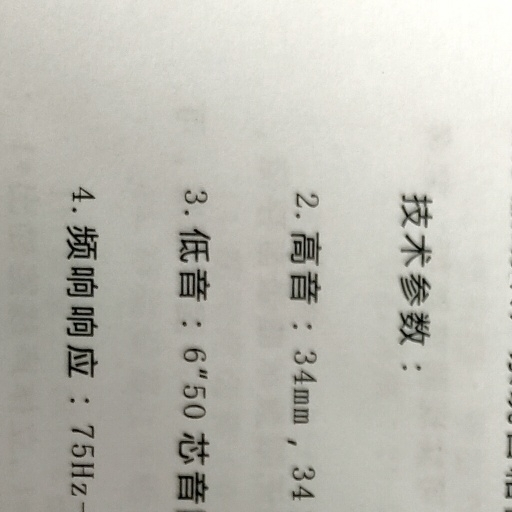

In [18]:
im1=Image.open("/mnt/d/work/DocTamper/tampered_1950.png").convert("RGB")
inp1=toctsr(im1)
im1

In [19]:
new_qtb = (
    np.array(
        [
            [2, 1, 1, 2, 2, 4, 5, 6],
            [1, 1, 1, 2, 3, 6, 6, 6],
            [1, 1, 2, 2, 4, 6, 7, 6],
            [1, 2, 2, 3, 5, 9, 8, 6],
            [2, 2, 4, 6, 7, 11, 10, 8],
            [2, 4, 6, 6, 8, 10, 11, 9],
            [5, 6, 8, 9, 10, 12, 12, 10],
            [7, 9, 10, 10, 11, 10, 10, 10],
        ],
        dtype=np.int32,
    )
    .reshape(
        64,
    )
    .tolist()
)

In [20]:
def crop_img(img, jpg_dct, crop_size=512, mask=None):
    if mask is None:
        use_mask = False
    else:
        use_mask = True
        crop_masks = []

    h, w, c = img.shape
    h_grids = h // crop_size
    w_grids = w // crop_size

    crop_imgs = []
    crop_jpe_dcts = []

    for h_idx in range(h_grids):
        for w_idx in range(w_grids):
            x1 = w_idx * crop_size
            x2 = x1 + crop_size
            y1 = h_idx * crop_size
            y2 = y1 + crop_size
            crop_img = img[y1:y2, x1:x2, :]
            crop_imgs.append(crop_img)
            crop_jpe_dct = jpg_dct[y1:y2, x1:x2]
            crop_jpe_dcts.append(crop_jpe_dct)
            if use_mask:
                if mask[y1:y2, x1:x2].max() != 0:
                    crop_masks.append(1)
                else:
                    crop_masks.append(0)

    if w % crop_size != 0:
        for h_idx in range(h_grids):
            y1 = h_idx * crop_size
            y2 = y1 + crop_size
            crop_imgs.append(img[y1:y2, w - 512 : w, :])
            crop_jpe_dcts.append(jpg_dct[y1:y2, w - 512 : w])
            if use_mask:
                if mask[y1:y2, w - 512 : w].max() != 0:
                    crop_masks.append(1)
                else:
                    crop_masks.append(0)

    if h % crop_size != 0:
        for w_idx in range(w_grids):
            x1 = w_idx * crop_size
            x2 = x1 + crop_size
            crop_imgs.append(img[h - 512 : h, x1:x2, :])
            crop_jpe_dcts.append(jpg_dct[h - 512 : h, x1:x2])
            if use_mask:
                if mask[h - 512 : h, x1:x2].max() != 0:
                    crop_masks.append(1)
                else:
                    crop_masks.append(0)

    if w % crop_size != 0 and h % crop_size != 0:
        crop_imgs.append(img[h - 512 : h, w - 512 : w, :])
        crop_jpe_dcts.append(jpg_dct[h - 512 : h, w - 512 : w])
        if use_mask:
            if mask[h - 512 : h, w - 512 : w].max() != 0:
                crop_masks.append(1)
            else:
                crop_masks.append(0)

    if use_mask:
        return crop_imgs, crop_jpe_dcts, h_grids, w_grids, crop_masks
    else:
        return crop_imgs, crop_jpe_dcts, h_grids, w_grids, None

In [21]:
def combine_img(imgs, h_grids, w_grids, img_h, img_w, crop_size=512):
    i = 0
    re_img = np.zeros((img_h, img_w))
    for h_idx in range(h_grids):
        for w_idx in range(w_grids):
            x1 = w_idx * crop_size
            x2 = x1 + crop_size
            y1 = h_idx * crop_size
            y2 = y1 + crop_size
            re_img[y1:y2, x1:x2] = imgs[i]
            i += 1

    if w_grids * crop_size < img_w:
        for h_idx in range(h_grids):
            y1 = h_idx * crop_size
            y2 = y1 + crop_size
            re_img[y1:y2, img_w - 512 : img_w] = imgs[i]
            i += 1

    if h_grids * crop_size < img_h:
        for w_idx in range(w_grids):
            x1 = w_idx * crop_size
            x2 = x1 + crop_size
            re_img[img_h - 512 : img_h, x1:x2] = imgs[i]
            i += 1

    if w_grids * crop_size < img_w and h_grids * crop_size < img_h:
        re_img[img_h - 512 : img_h, img_w - 512 : img_w] = imgs[i]

    return re_img

In [22]:
totsr = ToTensorV2()
toctsr =torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.455, 0.406), std=(0.229, 0.224, 0.225))
    ])

In [23]:
device=torch.device("cuda")
model=model.to(device)
print(device)

cuda


In [61]:
img_path = "/mnt/d/work/DocTamper/tampered_1953.png"
imgs_ori = cv2.imread(img_path)
imgs_ori.resize((512,512,3))
cv2.imwrite("/mnt/d/work/DocTamper/tempered_image.jpeg",imgs_ori)

True

In [62]:
img_path = "/mnt/d/work/DocTamper/tempered_image.jpeg"
imgs_ori = cv2.imread(img_path)
imgs_ori.resize((512,512,3))
h,w,c = imgs_ori.shape
jpg_dct = jpegio.read(img_path)
dct_ori = jpg_dct.coef_arrays[0].copy()
use_qtb2 = jpg_dct.quant_tables[0].copy()
print(h,w,c)

512 512 3


In [63]:

if h%8 == 0 and w%8 == 0:
    imgs_d = imgs_ori
    dct_d = dct_ori
else:
    imgs_d = imgs_ori[0:(h//8)*8,0:(w//8)*8,:].copy()
    dct_d = dct_ori[0:(h//8)*8,0:(w//8)*8].copy()
qs = torch.LongTensor(use_qtb2)
img_h, img_w, _ = imgs_d.shape
crop_imgs, crop_jpe_dcts, h_grids, w_grids, _= crop_img(imgs_d, dct_d, crop_size=512, mask=None)
img_list = []
for idx, crop in tqdm(enumerate(crop_imgs),total=len(crop_imgs)):
    crop = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
    data = toctsr(crop)
    dct = torch.LongTensor(crop_jpe_dcts[idx])

    data, dct, qs = data.unsqueeze(0).to(device), dct.unsqueeze(0).to(device), qs.unsqueeze(0).to(device)
    dct = torch.abs(dct).clamp(0,20)
    B,C,H,W = data.shape
    qs = qs.reshape(B,1,8,8)
    print(data.shape,dct.shape,qs.shape)
    with torch.no_grad():
        if data.size()[-2:]==torch.Size((512,512))  and dct.size()[-2:]==torch.Size((512,512)) and qs.size()[-2:]==torch.Size((8,8)):
            pred = model(data,dct,qs)
            pred = torch.nn.functional.softmax(pred,1)[:,1].cpu()
            img_list.append(((pred.cpu().numpy())*255).astype(np.uint8))
# ci = combine_img(img_list, h_grids, w_grids, img_h, img_w, crop_size=512)


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1, 3, 512, 512]) torch.Size([1, 512, 512]) torch.Size([1, 1, 8, 8])


In [64]:
padding = (0, 0, w-img_w, h-img_h)
ci = cv2.copyMakeBorder(img_list[0], padding[1], padding[3], padding[0], padding[2], cv2.BORDER_CONSTANT, value=[0, 0, 0])

In [65]:
ci.shape

(1, 512, 512)

In [57]:
import matplotlib.pyplot as plt

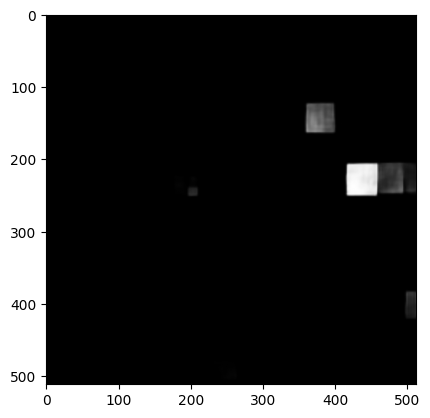

In [66]:
plt.imshow(ci[0],cmap='gray')